STEP 1: Read file from Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

#import os
#print(os.listdir('/content/drive/My Drive/'))
#print(os.listdir('/content/drive/MPI_NSF_NIH/scRNAseq_Datasets/'))

# Assuming the file is in your Google Drive under 'My Drive/'
# file_path = '/content/drive/My Drive/datasets/Biase_49_3.csv'  # Updated file path
# file_path = '/content/drive/My Drive/datasets/Deng_268_10.csv'  # Updated file path
# file_path = '/content/drive/My Drive/datasets/Goolam_124_5.csv'  # Updated file path
# file_path = '/content/drive/My Drive/datasets/Klein_2717_4.csv'  # Updated file path # trash data, ignore
# file_path = '/content/drive/My Drive/datasets/Ting_149_7.csv'  # Updated file path
# file_path = '/content/drive/My Drive/datasets/Treutlein_80_5.csv'  # Updated file path
file_path = '/content/drive/My Drive/datasets/Yan_90_7.csv'  # Updated file path

df = pd.read_csv(file_path)
df = df.T

# To see the contents of the dataframe, you can print it:
print(df.head())

# Display the plot.
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                          0            1                       2      \
Gene_ID                C9orf152        RPS11                   ELMO2   
Transcript_ID    NM_001012993,   NM_001015,   NM_133171, NM_182764,    
Oocyte #1(RPKM)             0.0     1219.861                   6.964   
Oocyte #2(RPKM)             0.0     1021.069                  12.195   
Oocyte #3(RPKM)             0.0       931.62                   9.299   

                       3            4                          5      \
Gene_ID              CREB3L1        PNMA1                       MMP2   
Transcript_ID    NM_052854,   NM_006029,   NM_001127891, NM_004530,    
Oocyte #1(RPKM)          1.0        0.679                        0.0   
Oocyte #2(RPKM)        1.424        1.343                        0.0   
Oocyte #3(RPKM)        1.946        2.125                        0.0   

     

STEP 2: This part is to read the file column by column and generate the PCA results

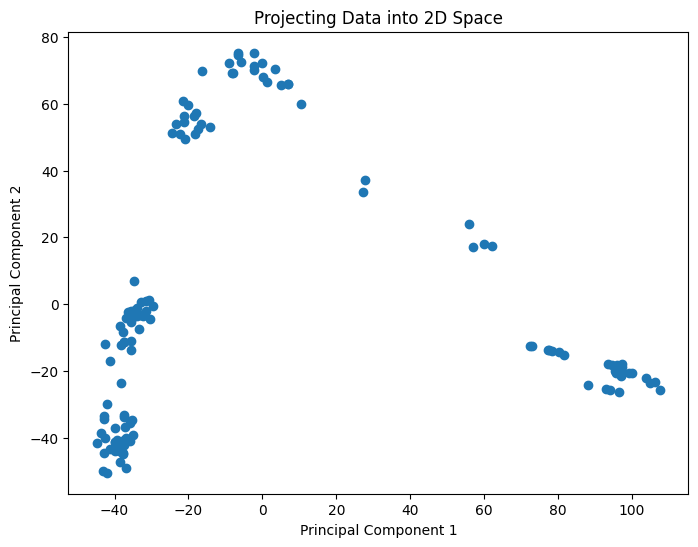

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Select the features for PCA
# Assuming 'ID' is the only non-numeric column you want to exclude
# features = [col for col in df.columns if col != 'Gene_ID' and col != 'Transcript_ID'] # Example
# features = [col for col in df.columns if col != 'Unnamed: 0'] # Biase3celltypes_49cells.csv
# features = [col for col in df.columns if col != 'Unnamed: 0'] # Deng_268cells.csv
# features = [col for col in df.columns if col != ''] # Goolam_123cells.csv
# features = [col for col in df.columns if col != 'ID'] # Klein_2727cells.csv
# features = [col for col in df.columns if col != 'Unnamed: 0'] # Ting_149cells.csv
# features = [col for col in df.columns] # Treutlein_80cells.csv
features = [col for col in df.columns if col != 'Gene_ID'] # Yan_90cells_7clusters.csv

X = df[features]

# 2. Convert all columns to numeric, errors='coerce' replaces non-numeric values with NaN
#    This is done before dropping NaNs to preserve more data if possible
X = X.apply(pd.to_numeric, errors='coerce')

# 3. Remove rows with any NaN values - now only removes rows that had NaNs originally OR
#    couldn't be converted to numeric
X = X.dropna()

# 4. If X is still empty after dropna(), fill NaN with 0 to avoid the error:
if X.empty:
    X = X.fillna(0)  # Fill remaining NaNs with 0

# 5. Standardize the data
x = StandardScaler().fit_transform(X)

# 6. Apply PCA
pca = PCA(n_components = 2) # Choose the number of components you want to keep
principal_components = pca.fit_transform(x)

# 7. Create a new dataframe with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

# 8. (Optional) Add back the 'Gene_ID' column if needed
# principal_df['Gene_ID'] = df['Gene_ID']

# 9. Visualize the results (example)
plt.figure(figsize=(8, 6))
plt.scatter(principal_df['principal component 1'], principal_df['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projecting Data into 2D Space')
plt.show()

STEP 3: The K-center algorithm with convex hulls drawn

Normalized Mutual Information (NMI): 0.5345375493223864
Normalized Mutual Information (NMI): 0.5345375493223864
Adjusted Rand Index (ARI): 0.0
Total area of convex hulls: 829.8150255485594


<ipython-input-3-f619193f3ddd>:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap


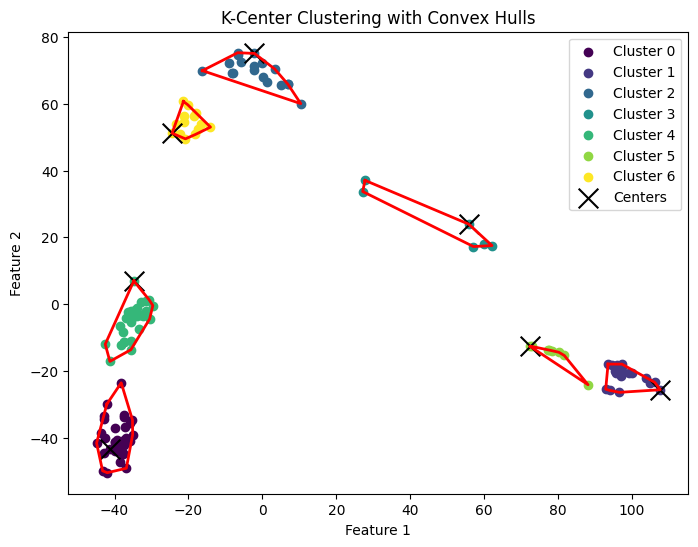

In [3]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull  # Import ConvexHull
from sklearn.metrics import normalized_mutual_info_score
# Add this import statement at the beginning of your code with the other imports
from sklearn.metrics import adjusted_rand_score


def k_center(data, k):
    """
    Implements the K-center algorithm for clustering.

    Args:
        data: A NumPy array representing the data points.
        k: The number of clusters.

    Returns:
        A tuple containing:
            - centers: A NumPy array of the cluster centers.
            - assignments: A NumPy array of cluster assignments for each data point.
    """

    # Convert DataFrame to NumPy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Initialize centers with a random data point
    centers = [data_array[np.random.choice(data_array.shape[0])]]

    # Iteratively select the remaining centers
    for _ in range(k - 1):
        distances = np.array([min([np.linalg.norm(point - center) for center in centers])
                              for point in data_array])
        farthest_point_index = np.argmax(distances)
        centers.append(data_array[farthest_point_index])

    # Assign data points to clusters
    assignments = np.array([np.argmin([np.linalg.norm(point - center)
                                       for center in centers])
                           for point in data_array])

    return np.array(centers), assignments


def plot_clusters(data, centers, assignments):
    """
    Plots the clusters with different colors and convex hulls in the same figure.

    Args:
        data: A NumPy array or pandas DataFrame representing the data points.
        centers: A NumPy array of the cluster centers.
        assignments: A NumPy array of cluster assignments for each data point.
    """

    # Convert DataFrame to NumPy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Get unique cluster labels and assign colors
    unique_labels = np.unique(assignments)
    num_clusters = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap

    # Create a single figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot data points with assigned colors
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[assignments == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   color=colors(i), label=f'Cluster {label}')

    # Plot cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=200,
               color='black', label='Centers')

    # Calculate and plot convex hulls for each cluster
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[assignments == label]
        if cluster_points.shape[0] >= 3:
            hull = ConvexHull(cluster_points)
            hull_vertices = hull.vertices
            polygon_points = cluster_points[hull_vertices]
            polygon_points = np.vstack([polygon_points, polygon_points[0]])  # Close the loop
            ax.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)  # Plot on the same axes
        else:
            print(f"Warning: Cluster {label} does not have enough points to calculate ConvexHull.")

    ax.set_xlabel('Feature 1')  # Replace with your actual feature names
    ax.set_ylabel('Feature 2')  # Replace with your actual feature names
    ax.set_title('K-Center Clustering with Convex Hulls')
    ax.legend()
    plt.show()

# Assuming 'principal_df' is your DataFrame from PCA (replace with your actual DataFrame)
data = principal_df  # Replace principal_df with your data if needed
k = 7  # Number of clusters

# Assuming your DataFrame is named 'df' and the column labels are your true labels
# true_labels = df.columns  # Get column labels  <- This line is incorrect
true_labels = df.index  # Use df.index to get the sample labels

# Convert true_labels to numerical values if they are not already
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)

# Apply k-center clustering
centers, assignments = k_center(data, k)

# Instead of filtering true_labels_encoded, which is causing the issue,
# we'll filter the original true_labels to match the data used for clustering:
filtered_true_labels = true_labels[true_labels.isin(data.index)]

# Now, encode the filtered true labels:
# true_labels_encoded = label_encoder.transform(filtered_true_labels) # Incorrect
# Correct way:
true_labels_encoded = label_encoder.fit_transform(data.index)  # Encode data.index directly

# Calculate NMI using the encoded true labels
nmi = normalized_mutual_info_score(true_labels_encoded, assignments)
print(f"Normalized Mutual Information (NMI): {nmi}")

total_area = 0  # Initialize total area

# Create a dictionary to store cluster DataFrames
cluster_dfs = {}

# Iterate through clusters and create DataFrames
for cluster_id in range(k):
    # Get indices of data points belonging to the current cluster
    cluster_indices = np.where(assignments == cluster_id)[0]

    # Create a DataFrame for the current cluster using the original data
    cluster_dfs[cluster_id] = data.iloc[cluster_indices]

    # Get the points for the current cluster
    points = cluster_dfs[cluster_id].values

    # Calculate the convex hull if there are enough points
    if points.shape[0] >= 3:
        hull = ConvexHull(points)
        total_area += hull.volume  # Add the area (volume in 2D) to the total
        hull_vertices = hull.vertices
        polygon_points = points[hull_vertices]
        polygon_points = np.vstack([polygon_points, polygon_points[0]])  # Close the loop

        # Plot the convex hull for the current cluster
        # plt.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)
    else:
        print(f"Warning: Cluster {cluster_id} does not have enough points to calculate ConvexHull.")

# Calculate NMI using the encoded true labels
nmi = normalized_mutual_info_score(true_labels_encoded, assignments)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Calculate ARI using the encoded true labels
ari = adjusted_rand_score(true_labels_encoded, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

print(f"Total area of convex hulls: {total_area}")

# Plot the clusters
plot_clusters(data, centers, assignments)

# Print the cluster DataFrames (optional)
# for cluster_id, cluster_df in cluster_dfs.items():
#     print(f"\nCluster {cluster_id} DataFrame:")
#     print(cluster_df)

STEP 4: The K-median algorithm with convex hulls drawn

Normalized Mutual Information (NMI): 0.5505810130032447
Adjusted Rand Index (ARI): 0.0
Total area of convex hulls: 1500.5089746888286


<ipython-input-4-8fd419960921>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap


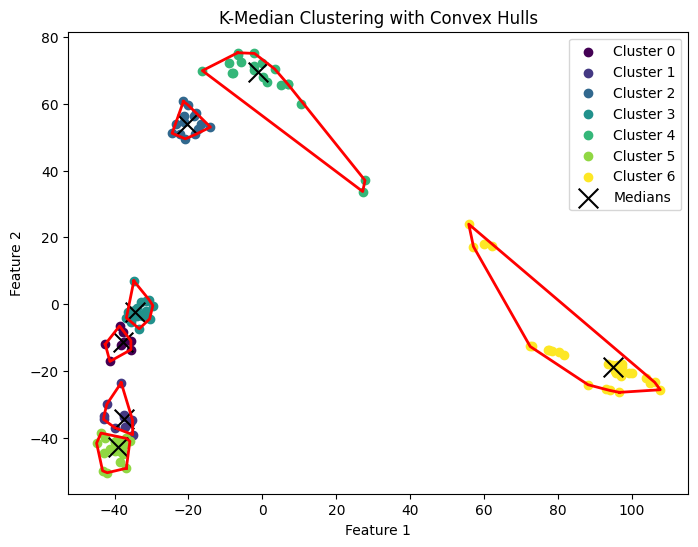

In [4]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull  # Import ConvexHull


def k_median(data, k, max_iterations=100):
    """
    Implements the K-median algorithm for clustering.

    Args:
        data: A NumPy array representing the data points.
        k: The number of clusters.
        max_iterations: The maximum number of iterations.

    Returns:
        A tuple containing:
            - medians: A NumPy array of the cluster medians.
            - assignments: A NumPy array of cluster assignments for each data point.
    """

    # Convert DataFrame to NumPy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Initialize medians randomly
    medians = data_array[np.random.choice(data_array.shape[0], size=k, replace=False)]

    # Iterate until convergence or maximum iterations
    for _ in range(max_iterations):
        # Assign data points to nearest medians
        distances = np.array([np.linalg.norm(data_array - median, axis=1) for median in medians])
        assignments = np.argmin(distances, axis=0)

        # Update medians
        new_medians = np.array([np.median(data_array[assignments == i], axis=0) for i in range(k)])

        # Check for convergence
        if np.all(medians == new_medians):
            break

        medians = new_medians

    return medians, assignments


def plot_clusters(data, medians, assignments):
    """
    Plots the clusters with different colors and convex hulls in the same figure.

    Args:
        data: A NumPy array or pandas DataFrame representing the data points.
        medians: A NumPy array of the cluster medians.
        assignments: A NumPy array of cluster assignments for each data point.
    """
    total_area = 0  # Initialize total_area inside the function

    # Convert DataFrame to NumPy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Get unique cluster labels and assign colors
    unique_labels = np.unique(assignments)
    num_clusters = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap

    # Create a single figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot data points with assigned colors
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[assignments == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   color=colors(i), label=f'Cluster {label}')

    # Plot cluster medians
    ax.scatter(medians[:, 0], medians[:, 1], marker='x', s=200,
               color='black', label='Medians')

    # Calculate and plot convex hulls for each cluster
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[assignments == label]
        if cluster_points.shape[0] >= 3:
            hull = ConvexHull(cluster_points)
            total_area += hull.volume  # Add the area (volume in 2D) to the total
            hull_vertices = hull.vertices
            polygon_points = cluster_points[hull_vertices]
            polygon_points = np.vstack([polygon_points, polygon_points[0]])  # Close the loop
            ax.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)  # Plot on the same axes
        else:
            print(f"Warning: Cluster {label} does not have enough points to calculate ConvexHull.")

    print(f"Total area of convex hulls: {total_area}")

    ax.set_xlabel('Feature 1')  # Replace with your actual feature names
    ax.set_ylabel('Feature 2')  # Replace with your actual feature names
    ax.set_title('K-Median Clustering with Convex Hulls')
    ax.legend()
    plt.show()


# Assuming 'principal_df' is your DataFrame from PCA (replace with your actual DataFrame)
data = principal_df  # Replace principal_df with your data if needed
k = 7  # Number of clusters

# Apply k-median clustering
medians, assignments = k_median(data, k)

# Instead of using df.index directly, get the true labels from data.index
true_labels = data.index  # Get the labels corresponding to the data used for clustering

# Convert true_labels to numerical values if they are not already
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)  # Encode the correct labels

# Calculate NMI using the encoded true labels
nmi = normalized_mutual_info_score(true_labels_encoded, assignments)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Calculate ARI using the encoded true labels
ari = adjusted_rand_score(true_labels_encoded, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Plot the clusters with convex hulls
plot_clusters(data, medians, assignments) # calling the function


STEP 5: The K-means algorithm with convex hulls drawn

Normalized Mutual Information (NMI): 0.5505810130032447
Adjusted Rand Index (ARI): 0.0
Total area of convex hulls: 1053.2186755542646


<ipython-input-5-39c09e754315>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap


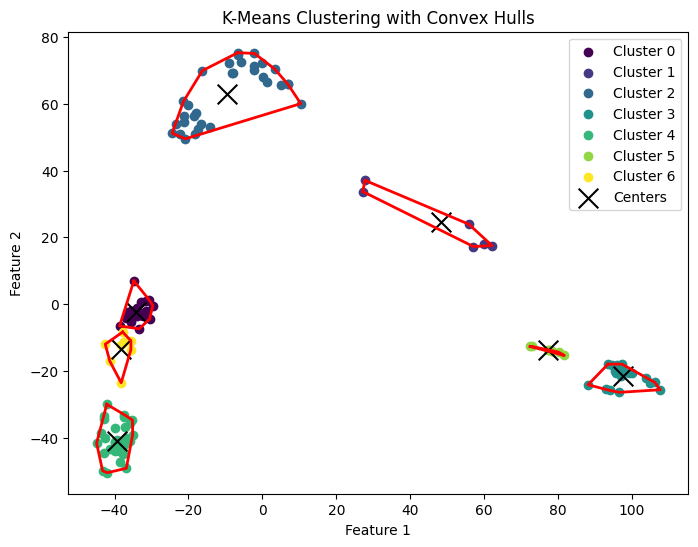

In [5]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  # Import KMeans
from scipy.spatial import ConvexHull  # Import ConvexHull

def plot_clusters(data, centers, labels):
    """
    Plots the clusters with different colors and convex hulls in the same figure.

    Args:
        data: A NumPy array or pandas DataFrame representing the data points.
        centers: A NumPy array of the cluster centers.
        labels: A NumPy array of cluster labels for each data point.
    """

    total_area = 0  # Initialize total_area inside the function

    # Convert DataFrame to NumPy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Get unique cluster labels and assign colors
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap

    # Create a single figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot data points with assigned colors
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[labels == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   color=colors(i), label=f'Cluster {label}')

    # Plot cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=200,
               color='black', label='Centers')

    # Calculate and plot convex hulls for each cluster
    for i, label in enumerate(unique_labels):
        cluster_points = data_array[labels == label]
        if cluster_points.shape[0] >= 3:
            hull = ConvexHull(cluster_points)
            total_area += hull.volume  # Add the area (volume in 2D) to the total
            hull_vertices = hull.vertices
            polygon_points = cluster_points[hull_vertices]
            polygon_points = np.vstack([polygon_points, polygon_points[0]])  # Close the loop
            ax.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)  # Plot on the same axes
        else:
            print(f"Warning: Cluster {label} does not have enough points to calculate ConvexHull.")

    print(f"Total area of convex hulls: {total_area}")

    ax.set_xlabel('Feature 1')  # Replace with your actual feature names
    ax.set_ylabel('Feature 2')  # Replace with your actual feature names
    ax.set_title('K-Means Clustering with Convex Hulls')
    ax.legend()
    plt.show()


# Assuming 'principal_df' is your DataFrame from PCA (replace with your actual DataFrame)
data = principal_df  # Replace principal_df with your data if needed
k = 7  # Number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0)  # You can change random_state if needed
kmeans.fit(data)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Instead of using df.index directly, get the true labels from data.index
true_labels = data.index  # Get the labels corresponding to the data used for clustering

# Convert true_labels to numerical values if they are not already
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)  # Encode the correct labels

# Calculate NMI using the encoded true labels
nmi = normalized_mutual_info_score(true_labels_encoded, assignments)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Calculate ARI using the encoded true labels
ari = adjusted_rand_score(true_labels_encoded, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Plot the clusters with convex hulls
plot_clusters(data, centers, labels)

STEP 6: The K-area algorithm with convex hulls drawn

STEP 6.1 Genrate the first convex hull

Total area of convex hulls: 10530.41602608508


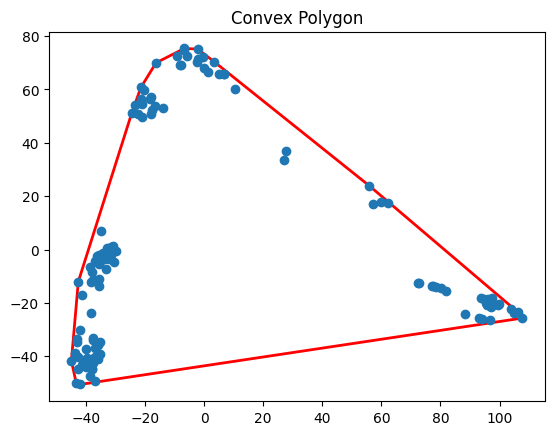

In [6]:
import pandas as pd
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has columns 'x' and 'y' for coordinates
# Replace 'x' and 'y' with your actual column names if they are different

total_area = 0  # Initialize total_area inside the function

# 1. Extract the coordinates
# points = df[['x', 'y']].values
points = principal_df.values

# 2. Calculate the convex hull
hull = ConvexHull(points)

# 3. Get the vertices of the convex hull
hull_vertices = hull.vertices

# 4. Create a polygon from the vertices
polygon_points = points[hull_vertices]
polygon_points = np.vstack([polygon_points, polygon_points[0]]) # Close the loop

total_area += hull.volume  # Add the area (volume in 2D) to the total
print(f"Total area of convex hulls: {total_area}")

# 5. (Optional) Plot the polygon
plt.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)
plt.plot(points[:, 0], points[:, 1], 'o')  # Plot original points as well
plt.title('Convex Polygon')
plt.show()

# Now you have the convex polygon defined by 'polygon_points'

STEP 6.2 Split a convex hull so that the total size is minimized.

Normalized Mutual Information (NMI): 0.5505810130032447
Adjusted Rand Index (ARI): 0.0
Total volume of convex hulls after 1 rounds: 3110.6215896213903


<ipython-input-19-c4cc1dff5916>:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap


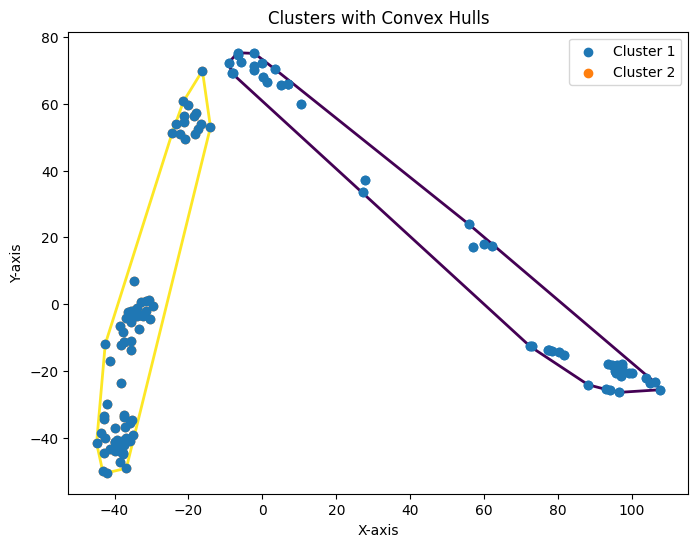

In [19]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def is_coplanar(points, tolerance=1e-12):
    """Checks if a set of points is coplanar within a tolerance."""
    if len(points) < 3:
        return True  # Points are coplanar if there are less than 3

    # Calculate vectors between points
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]

    # Check if the cross product is close to zero (indicating coplanarity)
    cross_product = np.cross(v1, v2)
    return np.allclose(cross_product, 0, atol=tolerance)

def repeat_split_hull_min_volume(points, k):
    """Repeats split_hull_min_volume k times, selecting the best cluster to split."""
    current_hulls = [points]  # Start with the original set of points
    total_area = 0  # Initialize total area

    for _ in range(k):
        min_total_volume = float('inf')
        best_hull1_points = None
        best_hull2_points = None
        best_hull_index = None

        # Iterate through current hulls to find the best split
        for i, hull_points in enumerate(current_hulls):
            if len(hull_points) >= 3:  # Check if hull has enough points
                hull1_points, hull2_points, total_volume = split_hull_min_volume(hull_points)

                # If this split results in lower total volume, update the best split
                if total_volume < min_total_volume:
                    min_total_volume = total_volume
                    best_hull1_points = hull1_points
                    best_hull2_points = hull2_points
                    best_hull_index = i

        # Update current_hulls with the best split
        if best_hull1_points is not None and best_hull2_points is not None:
            current_hulls[best_hull_index] = best_hull1_points
            current_hulls.append(best_hull2_points)
            total_area += min_total_volume  # Add the volume to the total

    return current_hulls, total_area

def split_hull_min_volume(points):
    """Splits a convex hull into two with minimized total volume."""
    min_total_volume = float('inf')
    best_hull1_points = None
    best_hull2_points = None

    # Iterate through pairs of vertices to define dividing lines
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            # Define the line equation using the two vertices
            p1 = points[i]
            p2 = points[j]

            # Handle vertical lines (avoid division by zero)
            if p2[0] - p1[0] == 0:
                a = float('inf')  # Set slope to infinity
                b = p1[0]  # Use x-coordinate as intercept for vertical line

                # Split points based on the vertical line
                hull1_points = [point for point in points if point[0] < b]
                hull2_points = [point for point in points if point[0] >= b]
            else:
                a = (p2[1] - p1[1]) / (p2[0] - p1[0])  # Slope
                b = p1[1] - a * p1[0]  # Intercept

                # Split points based on the line
                hull1_points = [point for point in points if point[1] > a * point[0] + b]
                hull2_points = [point for point in points if point[1] <= a * point[0] + b]

            # Calculate total volume if both hulls have enough points and are not coplanar
            if len(hull1_points) >= 3 and len(hull2_points) >= 3 and \
               not is_coplanar(hull1_points) and not is_coplanar(hull2_points):
                hull1 = ConvexHull(hull1_points)
                hull2 = ConvexHull(hull2_points)
                total_volume = hull1.volume + hull2.volume

                # Update best split if total volume is lower
                if total_volume < min_total_volume:
                    min_total_volume = total_volume
                    best_hull1_points = hull1_points
                    best_hull2_points = hull2_points

    return best_hull1_points, best_hull2_points, min_total_volume

def plot_split_hulls(points, hull1_points, hull2_points, old_points):
    """Plots the original points and the two split convex hulls."""
    plt.figure(figsize=(8, 6))

    # Plot original points
    plt.scatter(points[:, 0], points[:, 1], color='blue', label='Original Points')

    # Plot the first convex hull
    if hull1_points is not None and len(hull1_points) >= 3:
        hull1 = ConvexHull(hull1_points)
        hull1_x = [hull1_points[i][0] for i in hull1.vertices]
        hull1_y = [hull1_points[i][1] for i in hull1.vertices]

        # Close the hull by appending the first point to the end
        hull1_x.append(hull1_x[0])
        hull1_y.append(hull1_y[0])

        plt.plot(hull1_x, hull1_y, 'r-', lw=2, label='Hull 1')

    # Plot the second convex hull
    if hull2_points is not None and len(hull2_points) >= 3:
        hull2 = ConvexHull(hull2_points)
        hull2_x = [hull2_points[i][0] for i in hull2.vertices]
        hull2_y = [hull2_points[i][1] for i in hull2.vertices]

        # Close the hull by appending the first point to the end
        hull2_x.append(hull2_x[0])
        hull2_y.append(hull2_y[0])

        plt.plot(hull2_x, hull2_y, 'g-', lw=2, label='Hull 2')

    # Plot original points again on top of the hulls for better visibility
    plt.plot(old_points[:, 0], old_points[:, 1], 'o')

    plt.title('Split Convex Hulls with Minimized Total Volume')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

def repeat_split_hull_min_volume(points, k):
    """Repeats split_hull_min_volume k times, selecting the best cluster to split."""
    current_hulls = [points]  # Start with the original set of points
    total_area = 0  # Initialize total area

    for _ in range(k):
        min_total_volume = float('inf')
        best_hull1_points = None
        best_hull2_points = None
        best_hull_index = None

        # Iterate through current hulls to find the best split
        for i, hull_points in enumerate(current_hulls):
            if len(hull_points) >= 3:  # Check if hull has enough points
                hull1_points, hull2_points, total_volume = split_hull_min_volume(hull_points)

                # If this split results in lower total volume, update the best split
                if total_volume < min_total_volume:
                    min_total_volume = total_volume
                    best_hull1_points = hull1_points
                    best_hull2_points = hull2_points
                    best_hull_index = i

        # Update current_hulls with the best split
        if best_hull1_points is not None and best_hull2_points is not None:
            current_hulls[best_hull_index] = best_hull1_points
            current_hulls.append(best_hull2_points)
            total_area += min_total_volume  # Add the volume to the total

    return current_hulls, total_area


def calculate_total_hull_volume(clusters):
    """Calculates the total volume of convex hulls for a list of clusters."""
    total_volume = 0
    for cluster in clusters:
        if len(cluster) >= 3:
            hull = ConvexHull(cluster)
            total_volume += hull.volume
    return total_volume


def split_clusters_min_volume(points, k):
    """Splits clusters k times to minimize total hull volume."""
    clusters = [points]  # Start with all points in one cluster

    for _ in range(k):
        best_split_clusters = None
        min_total_volume = float('inf')

        # Iterate through existing clusters to find the best split
        for i, cluster in enumerate(clusters):
            if len(cluster) >= 3:  # Check if cluster has enough points
                # Split the current cluster using split_hull_min_volume
                hull1_points, hull2_points, _ = split_hull_min_volume(cluster)

                # If split is valid, calculate total volume for the new configuration
                if hull1_points is not None and hull2_points is not None:
                    temp_clusters = clusters[:i] + [hull1_points, hull2_points] + clusters[i+1:]
                    total_volume = calculate_total_hull_volume(temp_clusters)

                    # Update best split if total volume is lower
                    if total_volume < min_total_volume:
                        min_total_volume = total_volume
                        best_split_clusters = temp_clusters

        # Update clusters with the best split
        if best_split_clusters is not None:
            clusters = best_split_clusters

    return clusters, min_total_volume

def plot_clusters_with_hulls(clusters, points):
    """Plots clusters with their convex hulls and data points."""
    plt.figure(figsize=(8, 6))

    # Define colors here:
    num_clusters = len(clusters)  # Get the number of clusters
    colors = plt.cm.get_cmap('viridis', num_clusters)  # Using 'viridis' colormap

    for i, cluster in enumerate(clusters):
        # Convert cluster to a NumPy array before slicing
        cluster = np.array(cluster)

        # Plot data points for the cluster
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i + 1}')

        # Calculate and plot convex hull if cluster has enough points
        if len(cluster) >= 3:
            hull = ConvexHull(cluster)
            hull_vertices = hull.vertices
            polygon_points = cluster[hull_vertices]
            polygon_points = np.vstack([polygon_points, polygon_points[0]])  # Close the loop
            # plt.plot(polygon_points[:, 0], polygon_points[:, 1], 'r-', lw=2)  # Plot on the same axes
            plt.plot(polygon_points[:, 0], polygon_points[:, 1], color=colors(i), lw=2)

    # Plot original points again on top of the hulls for better visibility
    plt.plot(points[:, 0], points[:, 1], 'o')  # Assuming points is your original data

    plt.title('Clusters with Convex Hulls')
    plt.xlabel('X-axis')  # Replace with your actual feature names
    plt.ylabel('Y-axis')  # Replace with your actual feature names
    plt.legend()
    plt.show()

# Example usage:
points = principal_df.values  # Assuming 'principal_df' is your DataFrame
k = 1 # Number of splits (K)

# Perform the repeated split
current_hulls, total_area = repeat_split_hull_min_volume(points, k)
final_clusters, total_volume = split_clusters_min_volume(points, k)  # Using the new function

# Instead of using df.index directly, get the true labels from data.index
true_labels = data.index  # Get the labels corresponding to the data used for clustering

# Convert true_labels to numerical values if they are not already
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)  # Encode the correct labels

# Calculate NMI using the encoded true labels
nmi = normalized_mutual_info_score(true_labels_encoded, assignments)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Calculate ARI using the encoded true labels
ari = adjusted_rand_score(true_labels_encoded, assignments)
print(f"Adjusted Rand Index (ARI): {ari}")

# Print the total volume and plot the resulting clusters
print(f"Total volume of convex hulls after {k} rounds: {total_volume}")

plot_clusters_with_hulls(final_clusters, points)

STEP 7. Generate a bar chart.

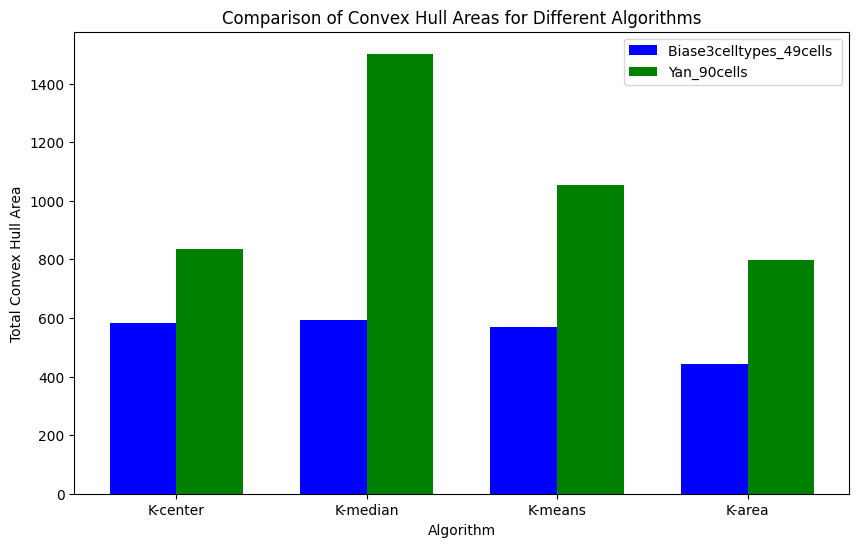

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Algorithm names for the x-axis labels
algorithms = ['K-center', 'K-median', 'K-means', 'K-area']

# Assuming you have these values from your previous calculations:
k_center_area =  584.3049137849594 # Replace with the total area from K-center
k_median_area =  593.5715052850489 # Replace with the total area from K-median
k_means_area =  567.6530105592357 # Replace with the total area from K-means
k_area_area =  443.095311064061 # Replace with the total area from K-area

# Existing areas (from your previous calculations)
Biase3celltypes_49cells = [k_center_area, k_median_area, k_means_area, k_area_area]

# New group of values to compare
Yan_90cells = [835.1307753766247, 1501.710114179605, 1053.2174299767769, 797.2400127521387]  # Replace with your actual new values

import matplotlib.pyplot as plt
import numpy as np

# Width of each bar
bar_width = 0.35

# Positions of the bars on the x-axis
x_pos_existing = np.arange(len(algorithms))
x_pos_new = [x + bar_width for x in x_pos_existing]

# Create the bar chart with both groups
plt.figure(figsize=(10, 6))
plt.bar(x_pos_existing, Biase3celltypes_49cells, color='blue', width=bar_width, label='Biase3celltypes_49cells ')
plt.bar(x_pos_new, Yan_90cells, color='green', width=bar_width, label='Yan_90cells')

# Customize the chart
plt.title('Comparison of Convex Hull Areas for Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Total Convex Hull Area')
plt.xticks([r + bar_width / 2 for r in range(len(algorithms))], algorithms)  # Center x-axis labels
plt.legend()
plt.show()